In [2]:
import sqlite3 
import re #Expressoes regulares
import time #Tempo/hora
import pycountry #Leitura de países em siglas formato ISO
import numpy as np #Manipulação de dados
import pandas as pd # ^^
import matplotlib.pyplot as plt #Criação de gráficos
import seaborn as sns # ^^
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer #Vetor para calculos
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style = "whitegrid")

In [4]:
!imdb-sqlite

2022-03-23 19:03:25,039 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads\name.basics.tsv.gz
2022-03-23 19:03:41,299 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads\title.basics.tsv.gz
2022-03-23 19:03:52,141 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads\title.akas.tsv.gz
2022-03-23 19:04:11,180 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads\title.principals.tsv.gz
2022-03-23 19:04:39,242 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads\title.episode.tsv.gz
2022-03-23 19:04:41,834 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads\title.ratings.tsv.gz
2022-03-23 19:04:42,407 Populating database: imdb.db
2022-03-23 19:04:42,428 Applying schema
2022-03-23 19:04:42,475 Importing file: downloads\name.basics.tsv.gz
2022-03-23 19:04:42,475 Reading number of rows ...
2022-03-23 19:04:49,282 Inserting rows into table: people

100%|██████████| 11503442/11503442 [03:29<00:00, 54997.33 rows/s]
20

In [4]:
conexao = sqlite3.connect("imdb.db")

In [8]:
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_name' FROM sqlite_master WHERE type ='table'", conexao)

#### Quais são os tipos mais comuns de obras no IMDB?

Se a obra é um longa metragem, um curta, um especial de TV, por exemplo

In [11]:
#Consulta SQL
consultaTipo = '''SELECT type,COUNT(*) AS COUNT FROM titles GROUP BY type'''

#Extração do resultado
resultadoTipo = pd.read_sql_query(consultaTipo, conexao)

#Cálculo percentual de cada gênero
resultadoTipo['percentual'] = (resultadoTipo['COUNT'] / resultadoTipo['COUNT'].sum()) * 100

#Exibição do resultado
display(resultadoTipo)

,type,COUNT,percentual
0,movie,605305,6.887192
1,short,861545,9.802703
2,tvEpisode,6585297,74.927849
3,tvMiniSeries,42678,0.485592
4,tvMovie,135481,1.541510
5,tvPilot,2,0.000023
6,tvSeries,222564,2.532345
7,tvShort,10510,0.119583
8,tvSpecial,36387,0.414013
9,video,258387,2.939941


In [12]:
#Ordenação e filtragem de dados
#Criação de um dicionário vazio
others = {}

#Filtro de no máximo 5% (categorias que possuem abaixo de 5% serão consideradas "others")
others['COUNT'] = resultadoTipo[resultadoTipo['percentual'] < 5]['COUNT'].sum()

#Gravação do percentual
others['percentual'] = resultadoTipo[resultadoTipo['percentual'] < 5]['percentual'].sum()

#Ajuste do nome
others['type'] = 'Others'

#Filtro dos demais tipos de obras (apenas 3 categorias pontuam mais de 5%)
resultadoTipo = resultadoTipo[resultadoTipo['percentual'] > 5]

#Concatenação com o dataframe das demais categorias
resultadoTipo = resultadoTipo.append(others, ignore_index = True)

#Ordenação do resultado
resultadoTipo = resultadoTipo.sort_values(by = 'COUNT', ascending = False)


<function matplotlib.pyplot.show(close=None, block=None)>

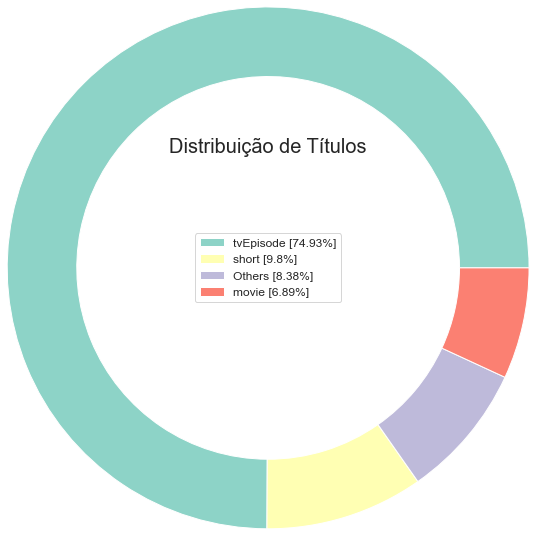

In [18]:
#Criação de gráficos
#Ajuste das labels
labels = [str(resultadoTipo['type'][i]) + ' ' + '[' + str(round(resultadoTipo['percentual'][i], 2)) + '%' + ']' for i in resultadoTipo.index]

#Escolha das cores
cs = cm.Set3(np.arange(100))

#Criação da figura
figura = plt.figure

#Gráfico de rosca
plt.pie(resultadoTipo['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size': 12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20, 'fontweight':20})
plt.show

#### Quais são os gêneros mais comuns de filmes no IMDB?


In [11]:
#"Selecione gêneros, contando todos a partir de títulos, onde o tipo é "filme", ordene por gênero"
consultaGenero = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

resultadoGenero = pd.read_sql_query(consultaGenero, conexao)



In [12]:
#Remoção de valores vazios (\N)
removeVazio = resultadoGenero['genres'].dropna()

In [14]:

display(resultadoGenero)

,genres,COUNT(*)
0,Action,13906
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1450,"Thriller,Western",44
1451,War,1291
1452,"War,Western",14
1453,Western,5156


In [18]:
#Criação de um count vectorizer

#Expressão regular para filtrar as strings
regex = '(?u)\\b[\\w-]+\\b'

#Construção do vetor
vetor = CountVectorizer(token_pattern = regex, analyzer = 'word').fit(removeVazio)

#Vetorização do dataset
bag_generos = vetor.transform(removeVazio)

#Retorno de gêneros únicos
generos_unicos = vetor.get_feature_names()

#Dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = removeVazio.index)

In [19]:
#Visualização parcial dos dados
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 1454
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1455 non-null   int64
 1   adult        1455 non-null   int64
 2   adventure    1455 non-null   int64
 3   animation    1455 non-null   int64
 4   biography    1455 non-null   int64
 5   comedy       1455 non-null   int64
 6   crime        1455 non-null   int64
 7   documentary  1455 non-null   int64
 8   drama        1455 non-null   int64
 9   family       1455 non-null   int64
 10  fantasy      1455 non-null   int64
 11  film-noir    1455 non-null   int64
 12  game-show    1455 non-null   int64
 13  history      1455 non-null   int64
 14  horror       1455 non-null   int64
 15  music        1455 non-null   int64
 16  musical      1455 non-null   int64
 17  mystery      1455 non-null   int64
 18  n            1455 non-null   int64
 19  news         1455 non-null   int64
 20  reality-

In [ ]:
#Remoção da coluna N, criada sem razão
generos = generos.drop(columns = 'n', axis = 0)

<function matplotlib.pyplot.show(close=None, block=None)>

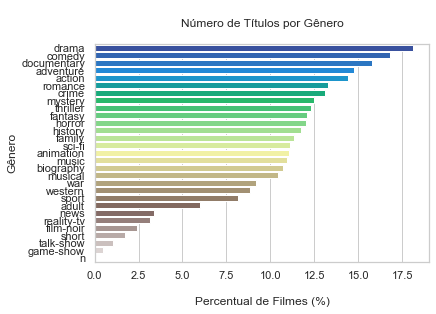

In [22]:
#Lapidação dos dados e criação do gráfico

#Percentual de gêneros
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

#Criação do plot
plt.Figure(figsize = (16, 8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain" )
plt.ylabel("Gênero")
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero de Títulos por Gênero\n')
plt.show